In [197]:
# imports and laodings
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
import statistics

# settings
basal_conditions = ['control__wt_glc__1', 'control__wt_glc__2'] #'crp__delar1ar2_glyc__2'

A_df = pd.read_csv('../data/precise_1.0/A.csv', index_col = 0)
iM_table = pd.read_csv('../data/precise_1.0/iM_table.csv', index_col = 0)
A_df = A_df.rename(index = {index : row['name'] for index, row in iM_table.iterrows()})

M_df = pd.read_csv('../data/precise_1.0/M.csv', index_col = 0)
M_df = M_df.rename(columns = {str(index) : row['name'] for index, row in iM_table.iterrows()})

log_tpm_df = pd.read_csv('../data/precise_1.0/log_tpm.csv', index_col = 0)
A_df = A_df[log_tpm_df.columns]

# defining constants
#RNAP = 1*10**(-8)
RNAP = 1*10**(-7)
kEscape = 1
TF = 0
#u = 1/3600
#kDeg = 0.00231049
#promoterConc = 1*10**(-9)
#promoterConcVal = 10**(-9)
#cell_volume = 10**(-15) # in liters

# getting grid values
pickle_in = open('../data/pickle_dicts/center_cond_to_gene_to_grid_values.pkl', 'rb')
center_cond_to_gene_to_grid_values = pickle.load(pickle_in)
pickle_in.close()
grid_vals = center_cond_to_gene_to_grid_values[basal_conditions[0]]['b1101']
grid_use = -3
KdRNAP = 10**(grid_vals[grid_use][0])
#kEscape = 10**(grid_vals[grid_use][1])
KeqOpening = 10**(grid_vals[grid_use][2])
KdRNAPCrp = 2.5118864315095796e-07*1.4

print(KdRNAP)
#print(kEscape)
print(KeqOpening)

if True:
    def mRNA_to_cActivator(mRNA, RNAP = RNAP, KdRNAP = KdRNAP, KdRNAPCrp = KdRNAPCrp, KeqOpening = KeqOpening): # this appears to be properly working!
        cActivator = (KdRNAPCrp*(KdRNAP + RNAP + KeqOpening*RNAP)*(-1 + \
                mRNA))/(KdRNAP*(KdRNAP + RNAP + KeqOpening*RNAP - \
                KdRNAPCrp*mRNA - RNAP*mRNA - KeqOpening*RNAP*mRNA))

        return(cActivator)

    def mRNA_to_cInhibitor(mRNA, RNAP = RNAP, KdRNAP = KdRNAP, KeqOpening = KeqOpening): # I think the mathematica code might have an error, I'm sticking with this
        cInhibitor = -(((KdRNAP + RNAP + KeqOpening*RNAP)*(-1 + mRNA))/(KdRNAP*mRNA))

        return(cInhibitor)


    def cActivator_cInhibitor_to_mRNA(cActivator, cInhibitor, RNAP = RNAP, KdRNAP = KdRNAP, KdRNAPCrp = KdRNAPCrp, KeqOpening = KeqOpening):
        mRNA = ((cActivator*KdRNAP + KdRNAPCrp)*(KdRNAP + RNAP + \
                KeqOpening*RNAP))/((1 + cActivator + cInhibitor)*KdRNAP*KdRNAPCrp + \
                cActivator*KdRNAP*(1 + KeqOpening)*RNAP + KdRNAPCrp*(1 + \
                KeqOpening)*RNAP)

        return(mRNA)

    def log_tpm_to_mRNA_conc(val):
        mRNA = (2**val)*(10**-6)*1800/cell_volume/(6.022*(10**23))
        return(mRNA)

1e-05
0.4524289955987184


In [16]:
df = pd.DataFrame(index = A_df.columns)
df['Crp-2_MA'] = A_df.loc['Crp-2']*M_df['Crp-2'].loc[gene]
df['DhaR/Mlc_MA'] = A_df.loc['DhaR/Mlc']*M_df['DhaR/Mlc'].loc[gene]
df.to_csv('MA.csv')

# recalculate A from a limited M

In [257]:
gene_iMs_df = pd.read_csv('../data/precise_1.0/gene_presence_matrix.csv', index_col = 0)
gene_iMs_df.columns = M_df.columns
zerod_genes = list(gene_iMs_df.index[[not val for val in gene_iMs_df[['Crp-2', 'DhaR/Mlc']].T.any()]])

zerod_M = M_df.copy()
zerod_M.loc[zerod_genes] = 0
# Calculate the inverse of DataFrame M
M_inverse = pd.DataFrame(np.linalg.pinv(zerod_M.values), zerod_M.columns, zerod_M.index)

# Solve for DataFrame A: A = M_inverse * X
#fixed_X = log_tpm_df.div(log_tpm_df[basal_conditions].mean(axis = 1), axis = 'index')
fixed_X = log_tpm_df.sub(log_tpm_df[basal_conditions].mean(axis = 1), axis = 'index')
fixed_X = fixed_X.fillna(0)
zerod_A_df = M_inverse.dot(fixed_X)

# calculate mRNA predicted and actual values

In [265]:
# I can't convert log tpm to mRNA without the gene counts from these
# settings
gene = 'b1101'
use_zerod_A = True
offset = 0 # setting the bottom or top to true zero makes the formulas weird, so I'm bumping everything off of that by X%

# setup
if use_zerod_A:
    A_df = zerod_A_df
    M_df = zerod_M

# crp is the activator
act_vals = []
mRNAs = []
index = []
actual_counts = []
MA_vals = []
log_x_un = min(A_df.loc['Crp-2']*M_df['Crp-2'].loc[gene])
log_x_c = log_tpm_df.loc[gene][basal_conditions].mean()
# predict mRNA values
for key, val in (A_df.loc['Crp-2']*M_df['Crp-2'].loc[gene]).items():
    index.append(key)
    MA_vals.append(val)
    mRNA = 2**(val-log_x_un)
    mRNAs.append(mRNA)
    actual_counts.append(2**(log_tpm_df.loc[gene][key]  - (log_x_c + log_x_un)))

act_values_df = pd.DataFrame(index = index)
act_values_df['mRNA'] = mRNAs
act_values_df['MA'] = MA_vals
act_values_df['actual_mRNA'] = actual_counts

# calculate activator values
for index, row in act_values_df.iterrows():
    mRNA = row['mRNA']
    cActivator = mRNA_to_cActivator(mRNA)
    act_vals.append(cActivator)
act_values_df['cActivator'] = act_vals
#act_values_df.hist()
act_values_df.to_pickle('../data/pickle_dfs/act_values_df.pkl')

In [266]:
#vecTest = A_df.loc['DhaR/Mlc']*M_df['DhaR/Mlc'].loc['b1101']-log_x_un
#vecTest.hist()

In [267]:
# mlc is the repressor
iM = 'DhaR/Mlc'
inh_vals = []
mRNAs = []
index = []
MA_vals = []
actual_counts = []
log_x_un = max(A_df.loc['DhaR/Mlc']*M_df['DhaR/Mlc'].loc[gene])
# predict mRNA values
for key, val in (A_df.loc[iM]*M_df[iM].loc[gene]).items():
    index.append(key)
    MA_vals.append(val)
    mRNA = 2**(val-log_x_un)
    mRNAs.append(mRNA)
    actual_counts.append(2**(log_tpm_df.loc[gene][key]-(log_x_c + log_x_un)))
inh_values_df = pd.DataFrame(index = index)
inh_values_df['mRNA'] = mRNAs
inh_values_df['MA'] = MA_vals
inh_values_df['actual_mRNA'] = actual_counts

# scale one by the other
# calculate inhibitor values
for index, row in inh_values_df.iterrows():
    mRNA = row['mRNA']
    cInhibitor = mRNA_to_cInhibitor(mRNA)
    inh_vals.append(cInhibitor)
inh_values_df['cInhibitor'] = inh_vals
#inh_values_df.hist(bins=20)
inh_values_df.to_pickle('../data/pickle_dfs/inh_values_df.pkl')

## similar to above, but relative to some set log tpm and all values in one dataframe

In [268]:
# TODOS - make this all relative prediction instead
control_value_log_tpm = 8.5

# I can't convert log tpm to mRNA without the gene counts from these
gene = 'b1101'

# crp is the activator
act_vals = []
mRNAs = []
index = []
actual_counts = []
MA_vals = []
log_x_c = log_tpm_df.loc[gene][basal_conditions].mean()
# predict mRNA values
for key, val in (A_df.loc[['DhaR/Mlc', 'Crp-2']].T.dot(M_df[['DhaR/Mlc', 'Crp-2']].loc['b1101'])).items():
    index.append(key)
    MA_vals.append(val)
    mRNA = 2**(val + log_x_c) / 2**(control_value_log_tpm)
    mRNAs.append(mRNA)
    actual_counts.append(2**(log_tpm_df.loc[gene][key]) / 2**(control_value_log_tpm))

act_values_df = pd.DataFrame(index = index)
act_values_df['mRNA_ratio'] = mRNAs
act_values_df['MA'] = MA_vals
act_values_df['actual_mRNA_ratio'] = actual_counts

#act_values_df.to_pickle('../data/pickle_dfs/inh_values_df.pkl')

In [270]:
act_values_df

,mRNA_ratio,MA,actual_mRNA_ratio
control__wt_glc__1,6.127346,-0.071322,6.184899
control__wt_glc__2,6.764136,0.071322,6.701193
fur__wt_dpd__1,2.399687,-1.423738,1.387462
fur__wt_dpd__2,1.926630,-1.740505,1.392493
fur__wt_fe__1,4.710436,-0.450723,4.969349
...,...,...,...
efeU__menFentCubiC_ale36__2,4.121102,-0.643554,5.925378
efeU__menFentCubiC_ale37__1,3.739693,-0.783664,4.918381
efeU__menFentCubiC_ale37__2,3.750708,-0.779421,4.751152
efeU__menFentCubiC_ale38__1,3.034648,-1.085055,5.128702


In [150]:
A_df[basal_conditions].loc['Crp-2']

control__wt_glc__1    0.35232
Name: Crp-2, dtype: float64

In [269]:
min((A_df.loc[['DhaR/Mlc', 'Crp-2']].T.dot(M_df[['DhaR/Mlc', 'Crp-2']].loc['b1101'])))

-2.453784590543718

In [143]:
M_df[['DhaR/Mlc', 'Crp-2']].loc['b1101']

DhaR/Mlc    0.116221
Crp-2       0.064359
Name: b1101, dtype: float64

In [144]:
0.3*.116 + 0.064*.35232

0.05734848

(-0.22649985026916586,
 13.059031720414097,
 0.18738281958890535,
 29.768674753862687)

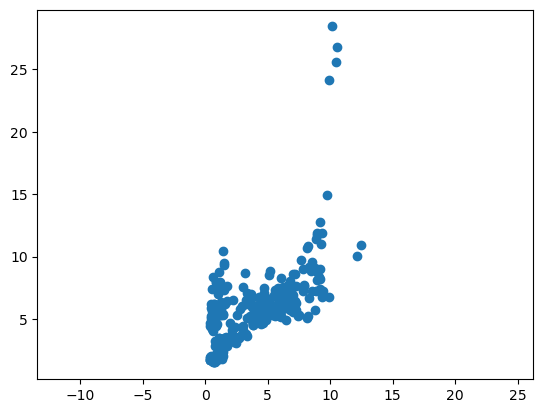

In [97]:
plt.scatter(act_values_df['actual_mRNA_ratio'], act_values_df['mRNA_ratio'])
plt.axis('equal')

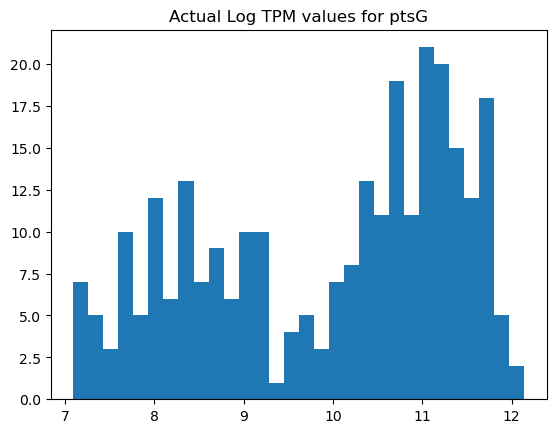

In [82]:
plt.hist(log_tpm_df.loc[gene], bins = 30)
plt.title('Actual Log TPM values for ptsG')
plt.show()

In [121]:
act_values_df.sort_values('mRNA_ratio')

,mRNA_ratio,MA,actual_mRNA_ratio
crp__delcrp_glc__1,1.531987,-2.013346,0.769693
crp__delcrp_glc__3,1.560959,-1.986318,0.708954
crp__delcrp_glyc__2,1.596310,-1.954010,0.634831
crp__delcrp_glc__2,1.603297,-1.947708,0.709340
crp__delcrp_glyc__3,1.682737,-1.877940,0.588118
...,...,...,...
minspan__wt_trp__1,14.970789,1.275328,9.713053
fps__fps_ptsI_ale3__1,24.119201,1.963360,9.936937
fps__fps_ptsI_ale3__2,25.606519,2.049689,10.458180
fps__fps_ptsI_ale1__1,26.742296,2.112301,10.523578


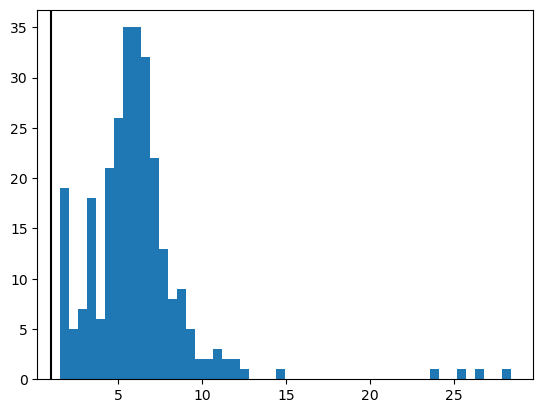

In [120]:
plt.hist(act_values_df['mRNA_ratio'], bins = 50)
plt.axvline(x = 1, color = 'k')

In [126]:
act_values_df.loc[act_values_df['actual_mRNA_ratio'] < 1]

,mRNA_ratio,MA,actual_mRNA_ratio
nac_ntrc__bw_delnac_csn__1,1.693823,-1.868467,0.921292
omics__bw_ac__2,7.255872,0.230399,0.978012
omics__bw_fum__1,5.202403,-0.249572,0.832131
omics__bw_fum__2,4.507391,-0.456457,0.866543
ompr__wt_nacl__1,2.139307,-1.531607,0.938126
...,...,...,...
pal__tartr_ale26__2,5.098119,-0.278785,0.663689
pal__tartr_ale28_f10__1,4.453710,-0.473742,0.892243
pal__tartr_ale28_f10__2,4.060050,-0.607253,0.642384
pal__tartr_ale28__1,6.064559,-0.028347,0.588720


array([[<Axes: title={'center': 'mRNA_ratio'}>,
        <Axes: title={'center': 'actual_mRNA_ratio'}>]], dtype=object)

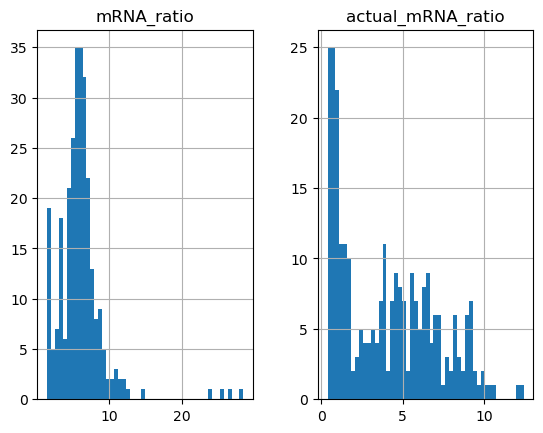

In [112]:
act_values_df[['mRNA_ratio', 'actual_mRNA_ratio']].hist(bins = 50)

In [ ]:
act_values_df.to_pickle('../data/pickle_dfs/spec_both_values_df.pkl')

# parameter optimization

Optimization successful.
KdRNAPCrp = 5.255359952695447e-06


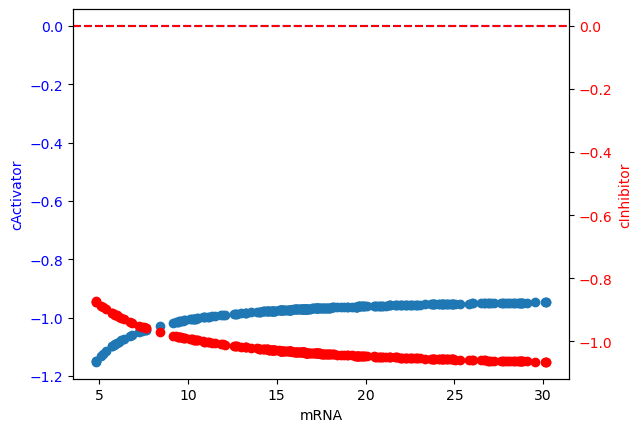

In [97]:
# chatGPT suggestion - use scipy to solve, only modify KdRNAPCrp
from scipy.optimize import basinhopping
import numpy as np

# modified using Griff's options
KdRNAP = 10**(grid_vals[grid_use][0])
kEscape = 10**(grid_vals[grid_use][1])
KeqOpening = 10**(grid_vals[grid_use][2])

activator_mRNA_values = list(act_values_df.sort_values(by = 'mRNA').mRNA.values)
inhibitor_mRNA_values = list(inh_values_df.sort_values(by = 'mRNA').mRNA.values)

def objective(x):
    KdRNAPCrp_temp = x[0]
    KdRNAP_temp = KdRNAP
    KeqOpening_temp = KeqOpening
    RNAP_temp = KdRNAP
    
    if KdRNAPCrp_temp > KdRNAP:
        # this doesn't make biological sense
        return(1e10) # return a high penalty
    
    cActivator_values = []
    for mRNA in activator_mRNA_values:
        cActivator = mRNA_to_cActivator(mRNA, RNAP = RNAP_temp, KdRNAP = KdRNAP_temp, KdRNAPCrp = KdRNAPCrp_temp, KeqOpening = KeqOpening_temp)
        cActivator_values.append(cActivator)
        
    cInhibitor_values = []
    for mRNA in inhibitor_mRNA_values:
        cInhibitor = mRNA_to_cInhibitor(mRNA, RNAP = RNAP_temp, KdRNAP = KdRNAP_temp, KeqOpening = KeqOpening_temp)
        cInhibitor_values.append(cInhibitor)
    
    penalty = 0
    diff = 0
    diff += abs(100 - abs(max(cActivator_values) - min(cActivator_values)))
    diff += abs((100 - abs((max(cInhibitor_values) - min(cInhibitor_values)))))
    
    #diff += abs(max(cActivator_values) - min(cActivator_values))
    #diff += abs(max(cInhibitor_values) - min(cInhibitor_values))
    
    if min(cActivator_values) < 0 or cActivator_values[-1] < cActivator_values[0]:
        penalty = 1e5  # Apply a large penalty if the criteria are not met
    elif min(cInhibitor_values) < 0 or cInhibitor_values[-1] > cInhibitor_values[0]:
        penalty = 1e5  # Apply a large penalty if the criteria are not met
    
    if cActivator_values[-1] < cActivator_values[0]:
        penalty = 1e5  # Apply a large penalty if the criteria are not met
    elif cInhibitor_values[-1] > cInhibitor_values[0]:
        penalty = 1e5  # Apply a large penalty if the criteria are not met
        
    return diff + penalty
    
# Initial guess for KdRNAP and KdRNAPCrp values
x0 = [KdRNAPCrp]#, KdRNAP, KeqOpening, RNAP]

# Bounds for KdRNAP and KdRNAPCrp values
n = 100000000
bounds = [(KdRNAPCrp/n, KdRNAPCrp*n)]#, (KdRNAP/n, KdRNAP*n), (KeqOpening/n, KeqOpening*n), (RNAP/n, RNAP*n)]

# basinhopping
result = basinhopping(objective,  x0 = x0, minimizer_kwargs={"bounds": bounds}, niter = 100)

if result.success:
    KdRNAPCrp_opt = result.x[0]
    print("Optimization successful.")
    print("KdRNAPCrp =", KdRNAPCrp_opt)
else:
    print("Optimization failed. Unable to find suitable values.")
    KdRNAPCrp_opt = result.x[0]
    print("KdRNAPCrp =", KdRNAPCrp_opt)
    
# plot
KdRNAPCrp_temp = result.x[0]
fig, ax = plt.subplots()
vals = mRNA_to_cActivator(act_values_df['mRNA'], KdRNAPCrp = KdRNAPCrp_temp)
ax.scatter(act_values_df['mRNA'], vals)
plt.xlabel('mRNA')
ax.set_ylabel('cActivator', color = 'blue')
ax.tick_params(axis = 'y', labelcolor = 'blue')
ax2 = ax.twinx()
vals = mRNA_to_cInhibitor(act_values_df['mRNA'])
ax2.scatter(act_values_df['mRNA'], vals, color = 'red')
ax2.set_ylabel('cInhibitor', color = 'red')
ax2.tick_params(axis = 'y', labelcolor = 'red')
#plt.axvline(x = log_tpm_to_mRNA_conc(log_tpm_df[controls].loc['b1101'].mean()), linestyle = '--', color = 'k')
ax2.axhline(y = 0, linestyle = '--', color = 'red')
ax.axhline(y = 0, linestyle = '--', color = 'blue')
plt.show()

1e-05


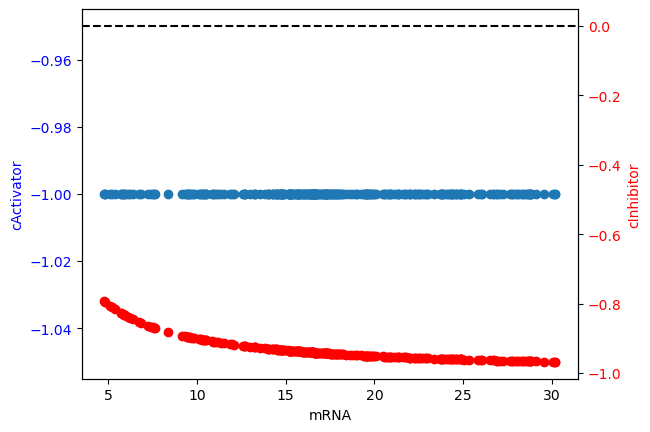

6.309573444801933e-06


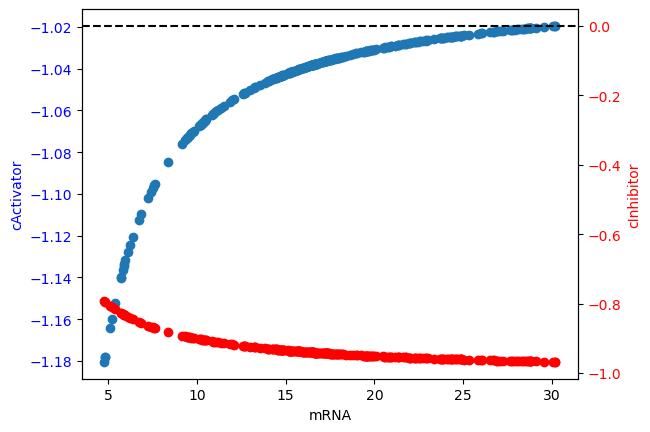

3.9810717055349725e-06


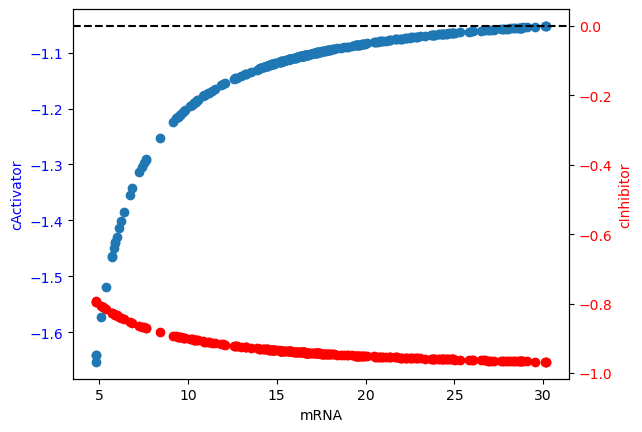

2.51188643150958e-06


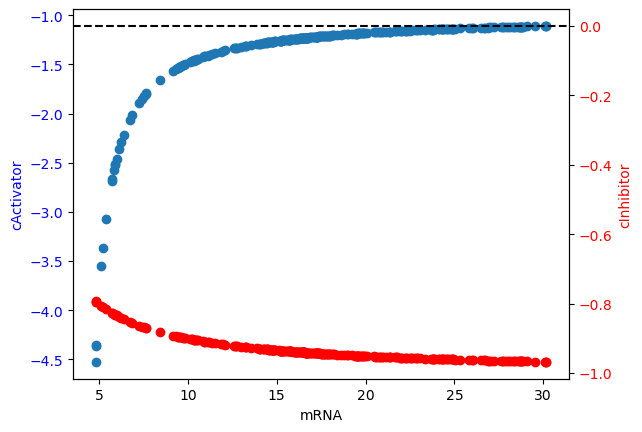

1.5848931924611137e-06


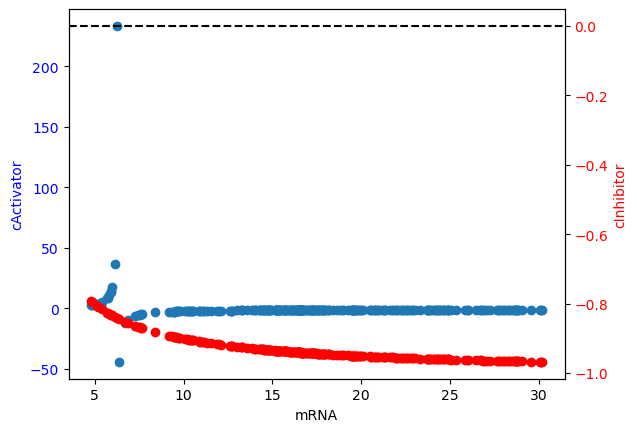

1.0000000000000002e-06


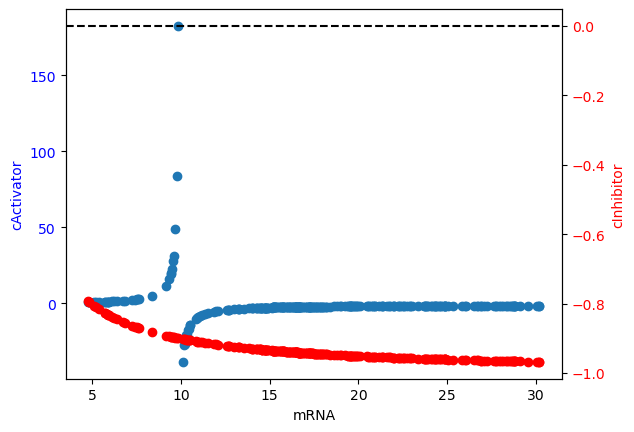

6.309573444801934e-07


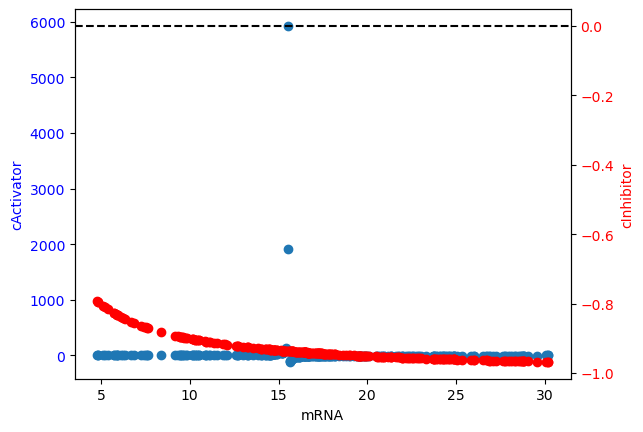

3.981071705534974e-07


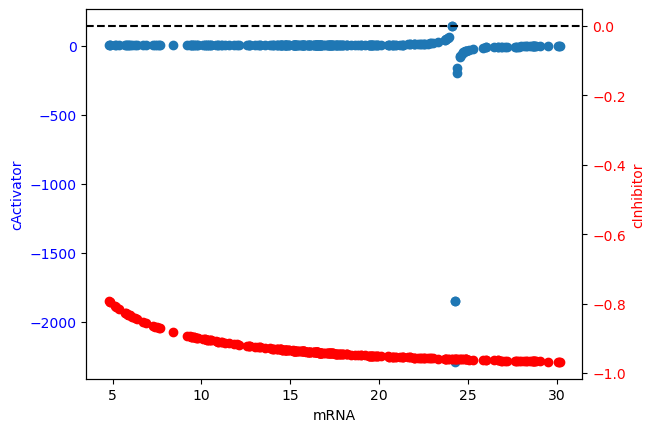

2.5118864315095796e-07


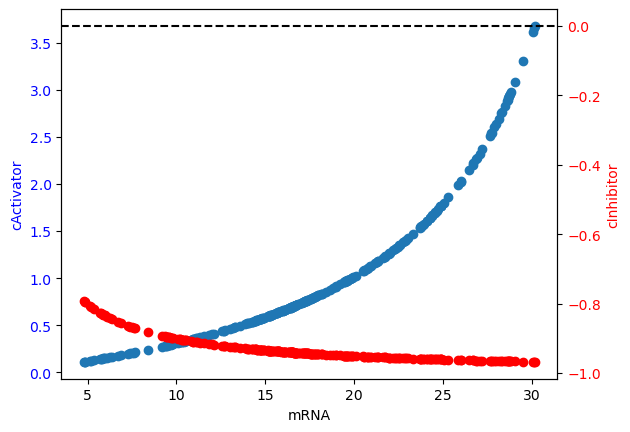

1.5848931924611136e-07


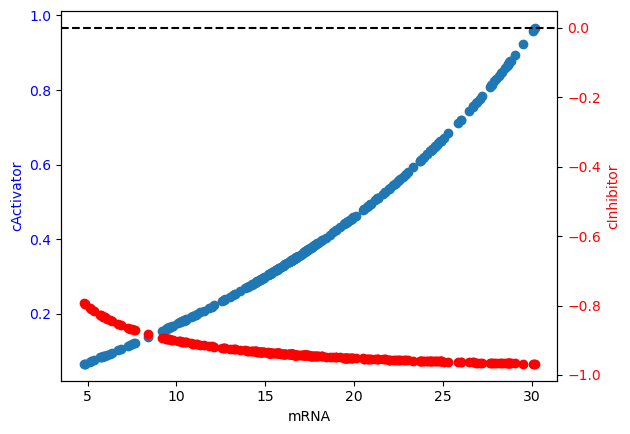

1.0000000000000001e-07


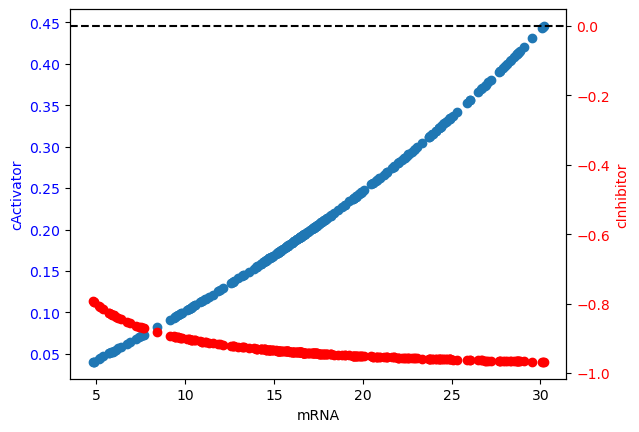

6.309573444801931e-08


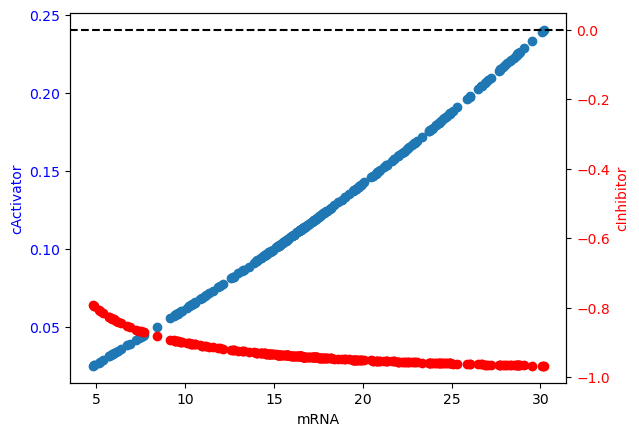

3.9810717055349736e-08


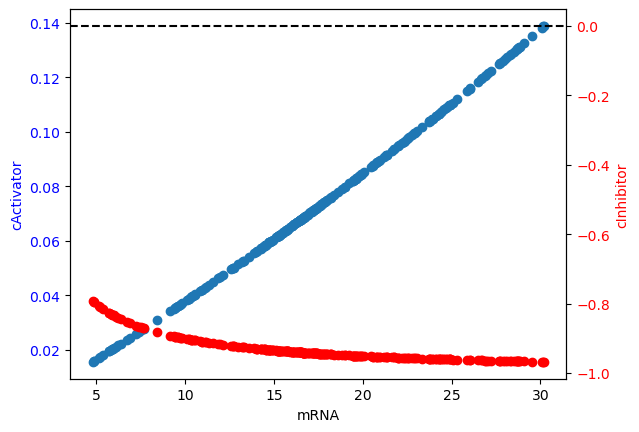

2.5118864315095798e-08


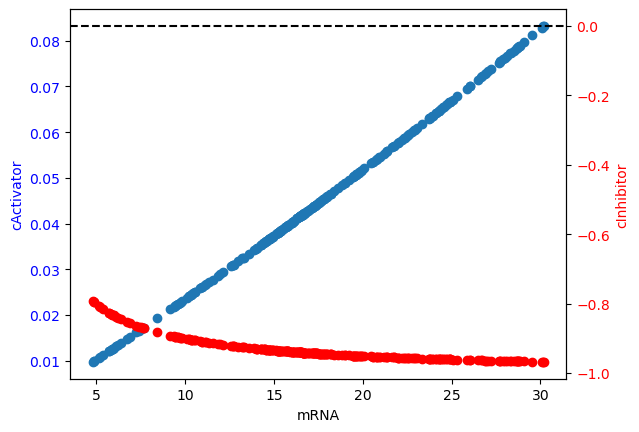

1.5848931924611143e-08


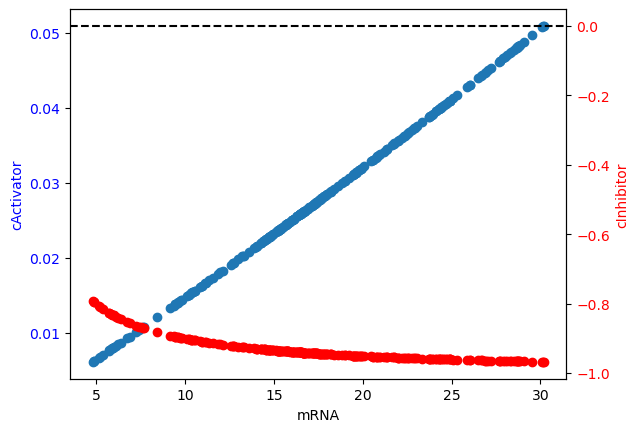

1e-08


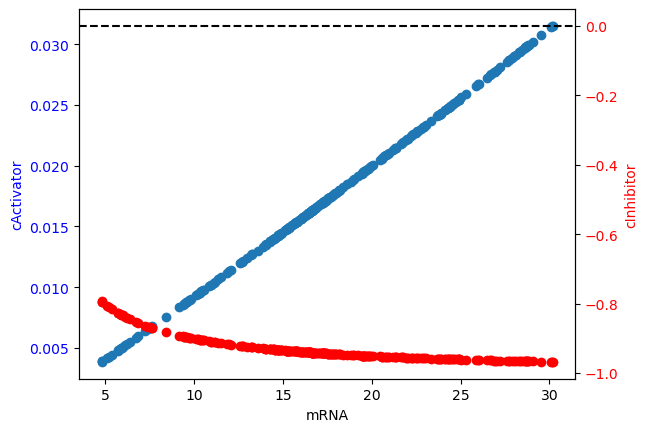

6.3095734448019305e-09


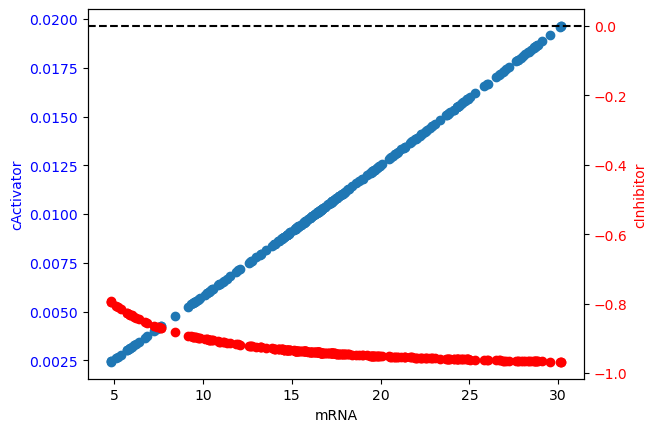

3.981071705534974e-09


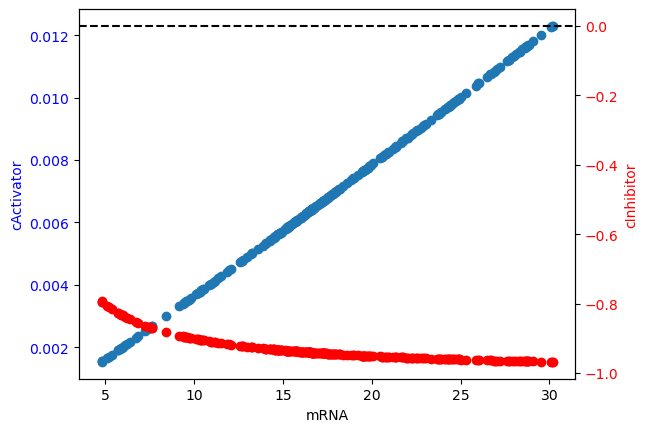

2.51188643150958e-09


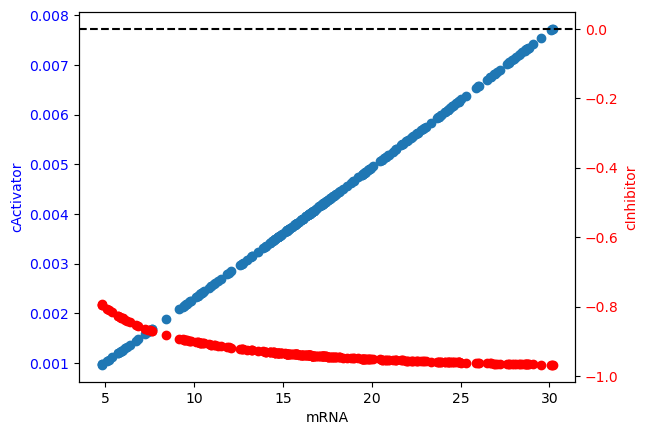

1.5848931924611142e-09


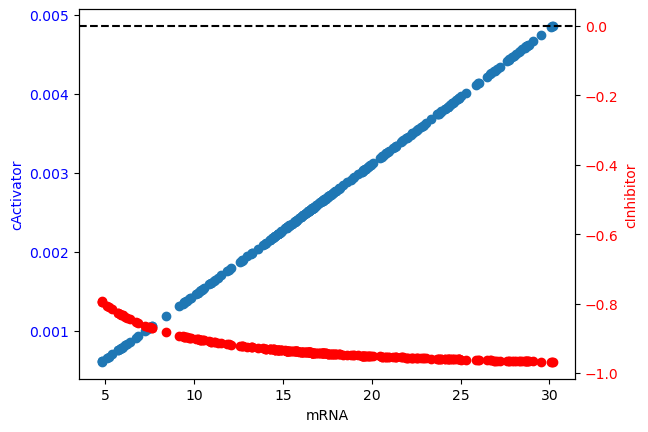

In [52]:
# Dan's suggestion - set cInhibitor to 0 to study cActivator and sweep values of KdRNAPCrp
# cInhibitor is not dependent on KdRNAPCrp so this doesn't really matter to it

# chatGPT suggestion - use scipy to solve, only modify KdRNAPCrp
from scipy.optimize import basinhopping
import numpy as np

# modified using Griff's options
grid_use = -1
KdRNAP = 10**(grid_vals[grid_use][0])
kEscape = 10**(grid_vals[grid_use][1])
KeqOpening = 10**(grid_vals[grid_use][2])


# plot
for val in range(20):
    KdRNAPCrp_temp = KdRNAP*10**(-val/5)
    print(KdRNAPCrp_temp)
    fig, ax = plt.subplots()
    vals = mRNA_to_cActivator(act_values_df['mRNA'], KdRNAPCrp = KdRNAPCrp_temp)
    ax.scatter(act_values_df['mRNA'], vals)
    plt.xlabel('mRNA')
    ax.set_ylabel('cActivator', color = 'blue')
    ax.tick_params(axis = 'y', labelcolor = 'blue')
    #ax.set_ylim(-max(abs(vals)), max(abs(vals)))
    ax2 = ax.twinx()
    vals = mRNA_to_cInhibitor(act_values_df['mRNA'])
    ax2.scatter(act_values_df['mRNA'], vals, color = 'red')
    ax2.set_ylabel('cInhibitor', color = 'red')
    ax2.tick_params(axis = 'y', labelcolor = 'red')
    #ax2.set_ylim(-max(abs(vals)), max(abs(vals)))
    #plt.axvline(x = log_tpm_to_mRNA_conc(log_tpm_df[controls].loc['b1101'].mean()), linestyle = '--', color = 'k')
    #plt.axvline(x = act_values_df.loc[controls]['mRNA'].mean(), linestyle = 'dotted', color = 'k')
    ax2.axhline(y = 0, linestyle = '--', color = 'k')
    plt.show()

In [ ]:
np.linspace(0, 10, 10)

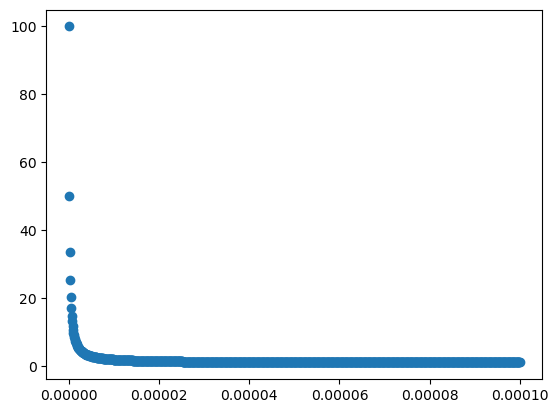

In [25]:
# I want to move the vTransc line

# modified using Griff's options
grid_use = -1
KdRNAP = 10**(grid_vals[grid_use][0])
kEscape = 10**(grid_vals[grid_use][1])
KeqOpening = 10**(grid_vals[grid_use][2])
KdRNAPCrp = KdRNAP / 100
x_vals = []
y_vals = []
for x_val in np.linspace(RNAP/100000000, RNAP*100, 1000):
    vTransc = (KdRNAP + x_val + KeqOpening*x_val)/(KdRNAPCrp + x_val + KeqOpening*x_val)
    y_vals.append(vTransc)
    x_vals.append(x_val)
plt.scatter(x_vals, y_vals)
plt.show()

# predicting

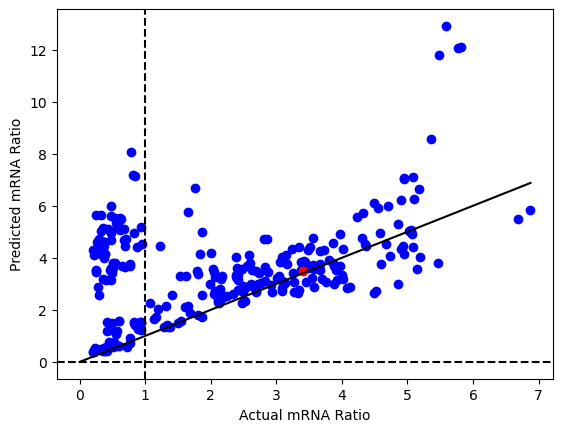

In [5]:
# let's convert A matrix values to cActivator and cInhibitor values
# start with just plotting them against each other
KdRNAPCrp = 2.5118864315095796e-07*3.5
predicted_mRNA = []
actual_mRNA = list(act_values_df.actual_mRNA)
for index in act_values_df.index:
    cActivator 
cActivator_cInhibitor_to_mRNA
cActivator_vals = np.array([mRNA_to_cActivator(val, KdRNAPCrp = KdRNAPCrp) for val in act_values_df['mRNA'].values]).clip(min = 0)
cInhibitor_vals = np.array(mRNA_to_cInhibitor(inh_values_df['mRNA'])).clip(min = 0)
predicted_mRNA = cActivator_cInhibitor_to_mRNA(cActivator_vals, cInhibitor_vals)
unhighlighted = []
highlighted = []
for index in act_values_df.index:
    if index in basal_conditions:
        highlighted.append(index)
    else:
        unhighlighted.append(index)
        
# use these cActivator and cInhibitor values to calculate ptsG tpm and compare to known
cActivator_vals = np.array(mRNA_to_cActivator(act_values_df['mRNA'].loc[unhighlighted], KdRNAPCrp = KdRNAPCrp)).clip(min = 0)
cInhibitor_vals = np.array(mRNA_to_cInhibitor(inh_values_df['mRNA'].loc[unhighlighted])).clip(min = 0)
predicted_mRNA = cActivator_cInhibitor_to_mRNA(cActivator_vals, cInhibitor_vals)
actual_mRNA = list(act_values_df.loc[unhighlighted].actual_mRNA)
plt.scatter(actual_mRNA, predicted_mRNA, color = 'blue')

cActivator_vals = np.array(mRNA_to_cActivator(act_values_df['mRNA'].loc[highlighted], KdRNAPCrp = KdRNAPCrp)).clip(min = 0)
cInhibitor_vals = np.array(mRNA_to_cInhibitor(inh_values_df['mRNA'].loc[highlighted])).clip(min = 0)
predicted_mRNA = cActivator_cInhibitor_to_mRNA(cActivator_vals, cInhibitor_vals)
actual_mRNA = list(act_values_df.loc[highlighted].actual_mRNA)
plt.scatter(actual_mRNA, predicted_mRNA, color = 'red')

plt.xlabel('Actual mRNA Ratio')
plt.ylabel('Predicted mRNA Ratio')
plt.axvline(x = 1, color = 'k', linestyle = '--')
plt.axhline(y = 0, color = 'k', linestyle = '--')
#plt.axis('equal')
plt.plot([0, max(act_values_df.actual_mRNA)], [0, max(act_values_df.actual_mRNA)], color = 'k')
plt.show()

In [32]:
# save our predictions
def calculate_z_scores(data):
    mean = statistics.mean(data)
    stdev = statistics.stdev(data)
    z_scores = [(x - mean) / stdev for x in data]
    return z_scores

preds_df = pd.DataFrame(index = act_values_df.index)
cActivator_vals = np.array(mRNA_to_cActivator(act_values_df['mRNA'], KdRNAPCrp = KdRNAPCrp)).clip(min = 0)
cInhibitor_vals = np.array(mRNA_to_cInhibitor(inh_values_df['mRNA'])).clip(min = 0)
predicted_mRNA = cActivator_cInhibitor_to_mRNA(cActivator_vals, cInhibitor_vals)
preds_df['cActivator_z'] = np.array(calculate_z_scores(cActivator_vals)).clip(min = 0.01)
preds_df['cInhibitor_z'] = np.array(calculate_z_scores(cInhibitor_vals)).clip(min = 0.01)
preds_df['cActivator_vals_unit'] = preds_df['cActivator_z'] / (preds_df['cActivator_z']  + preds_df['cInhibitor_z'])
preds_df['cInhibitor_vals_unit'] = preds_df['cInhibitor_z'] / (preds_df['cActivator_z']  + preds_df['cInhibitor_z'])
preds_df['predicted_mRNA_fold_change'] = predicted_mRNA
preds_df['predicted_log_tpm'] = np.log2(predicted_mRNA) + min(A_df.loc['Crp-2']*M_df['Crp-2'].loc[gene]) + log_tpm_df.loc[gene][basal_conditions].mean()#*preds_df['cActivator_vals_unit'] + max(A_df.loc['Crp-2']*M_df['Crp-2'].loc[gene])*preds_df['cInhibitor_vals_unit']
preds_df['actual_log_tpm'] = log_tpm_df.loc[gene][preds_df.index]
preds_df['difference'] = preds_df['predicted_log_tpm'] - preds_df['actual_log_tpm']
# I want a more complex way to add back in the bottom condition

preds_df.to_pickle('../data/saved_ptsG_predictions.pkl')

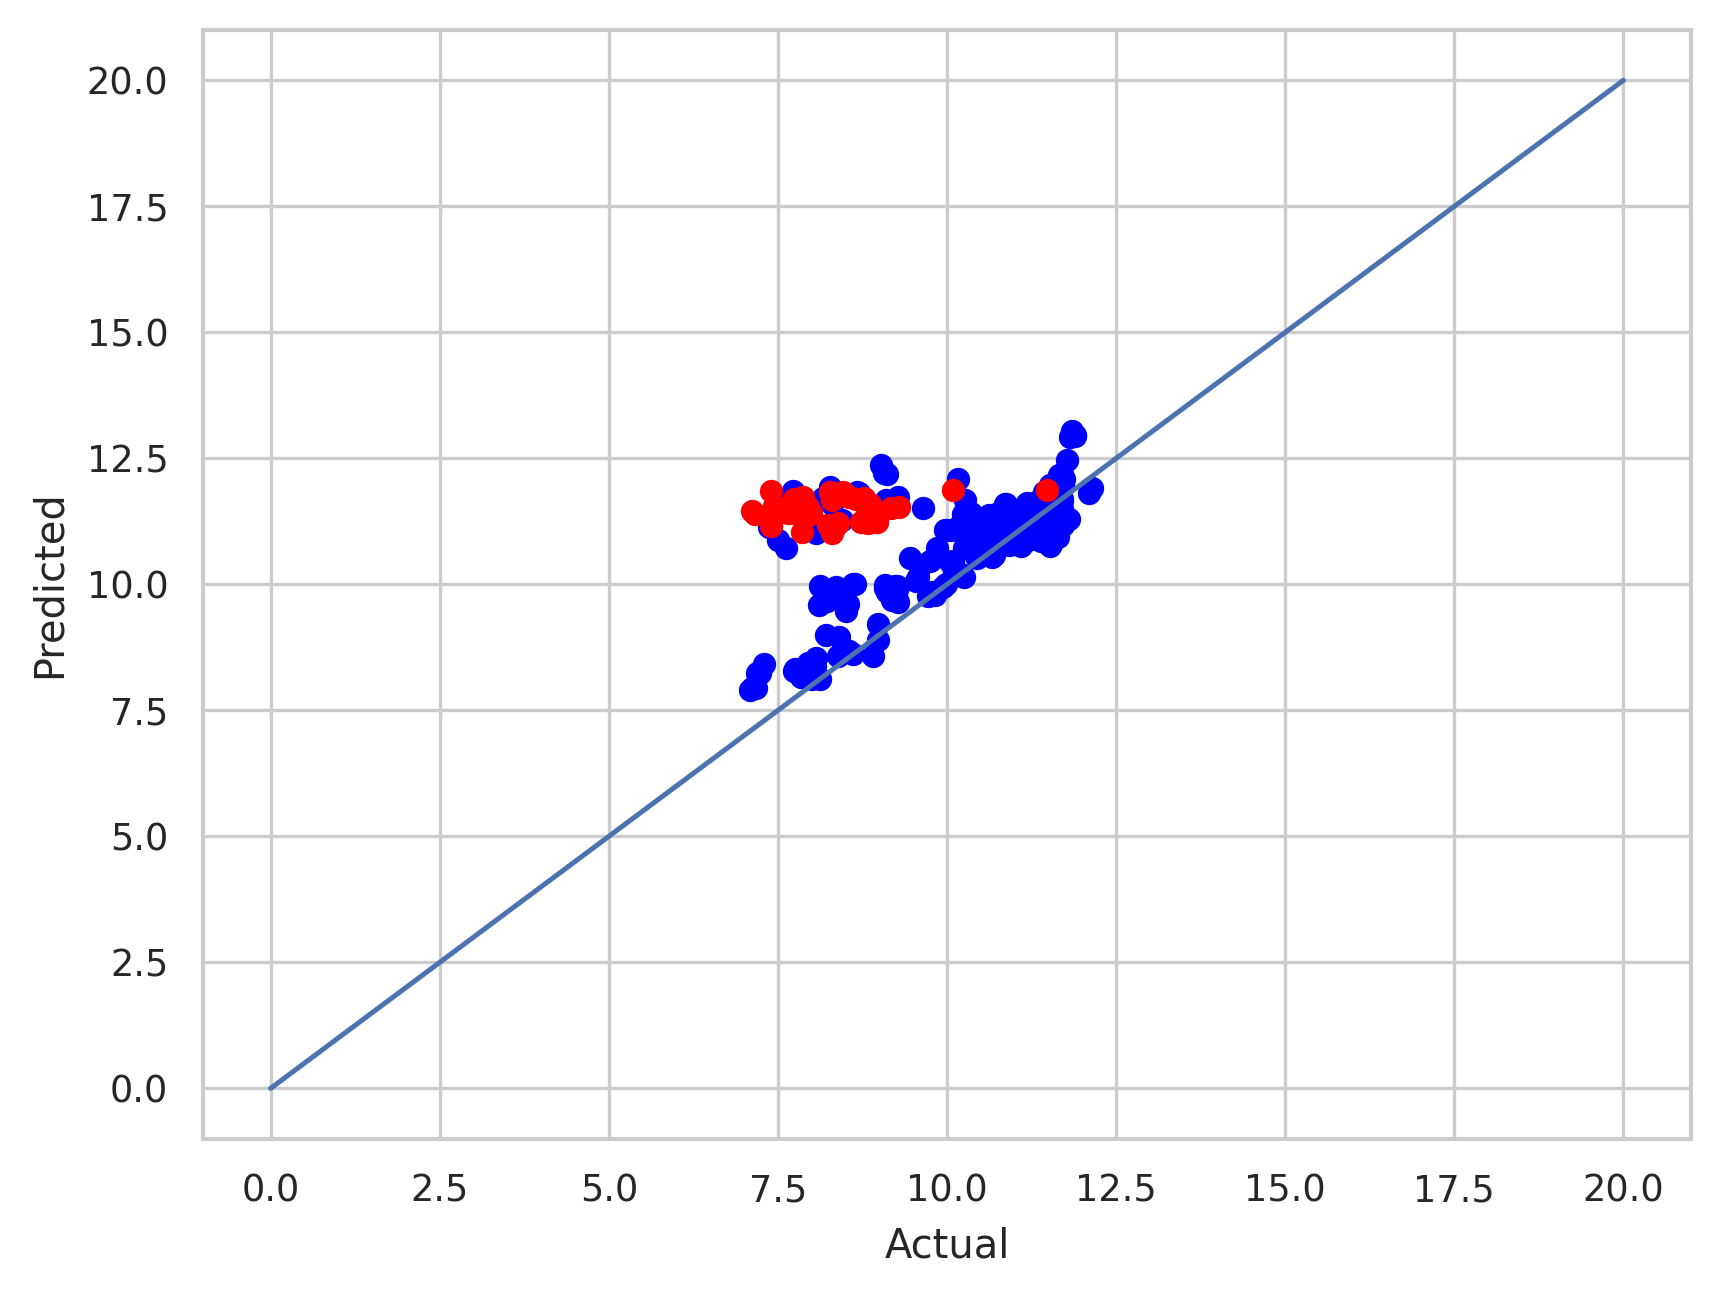

In [33]:
# 2D show predictions accuracy
over = preds_df.index[[row['cActivator_z'] > .5 and row['cInhibitor_z'] > .5 for _, row in preds_df.iterrows()]]
under = list(set(preds_df.index) - set(over))
fig = plt.figure()
plt.scatter(preds_df['actual_log_tpm'].loc[under], preds_df['predicted_log_tpm'].loc[under], color = 'blue')
plt.scatter(preds_df['actual_log_tpm'].loc[over], preds_df['predicted_log_tpm'].loc[over], color = 'red')
plt.plot([0, 20], [0, 20])
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

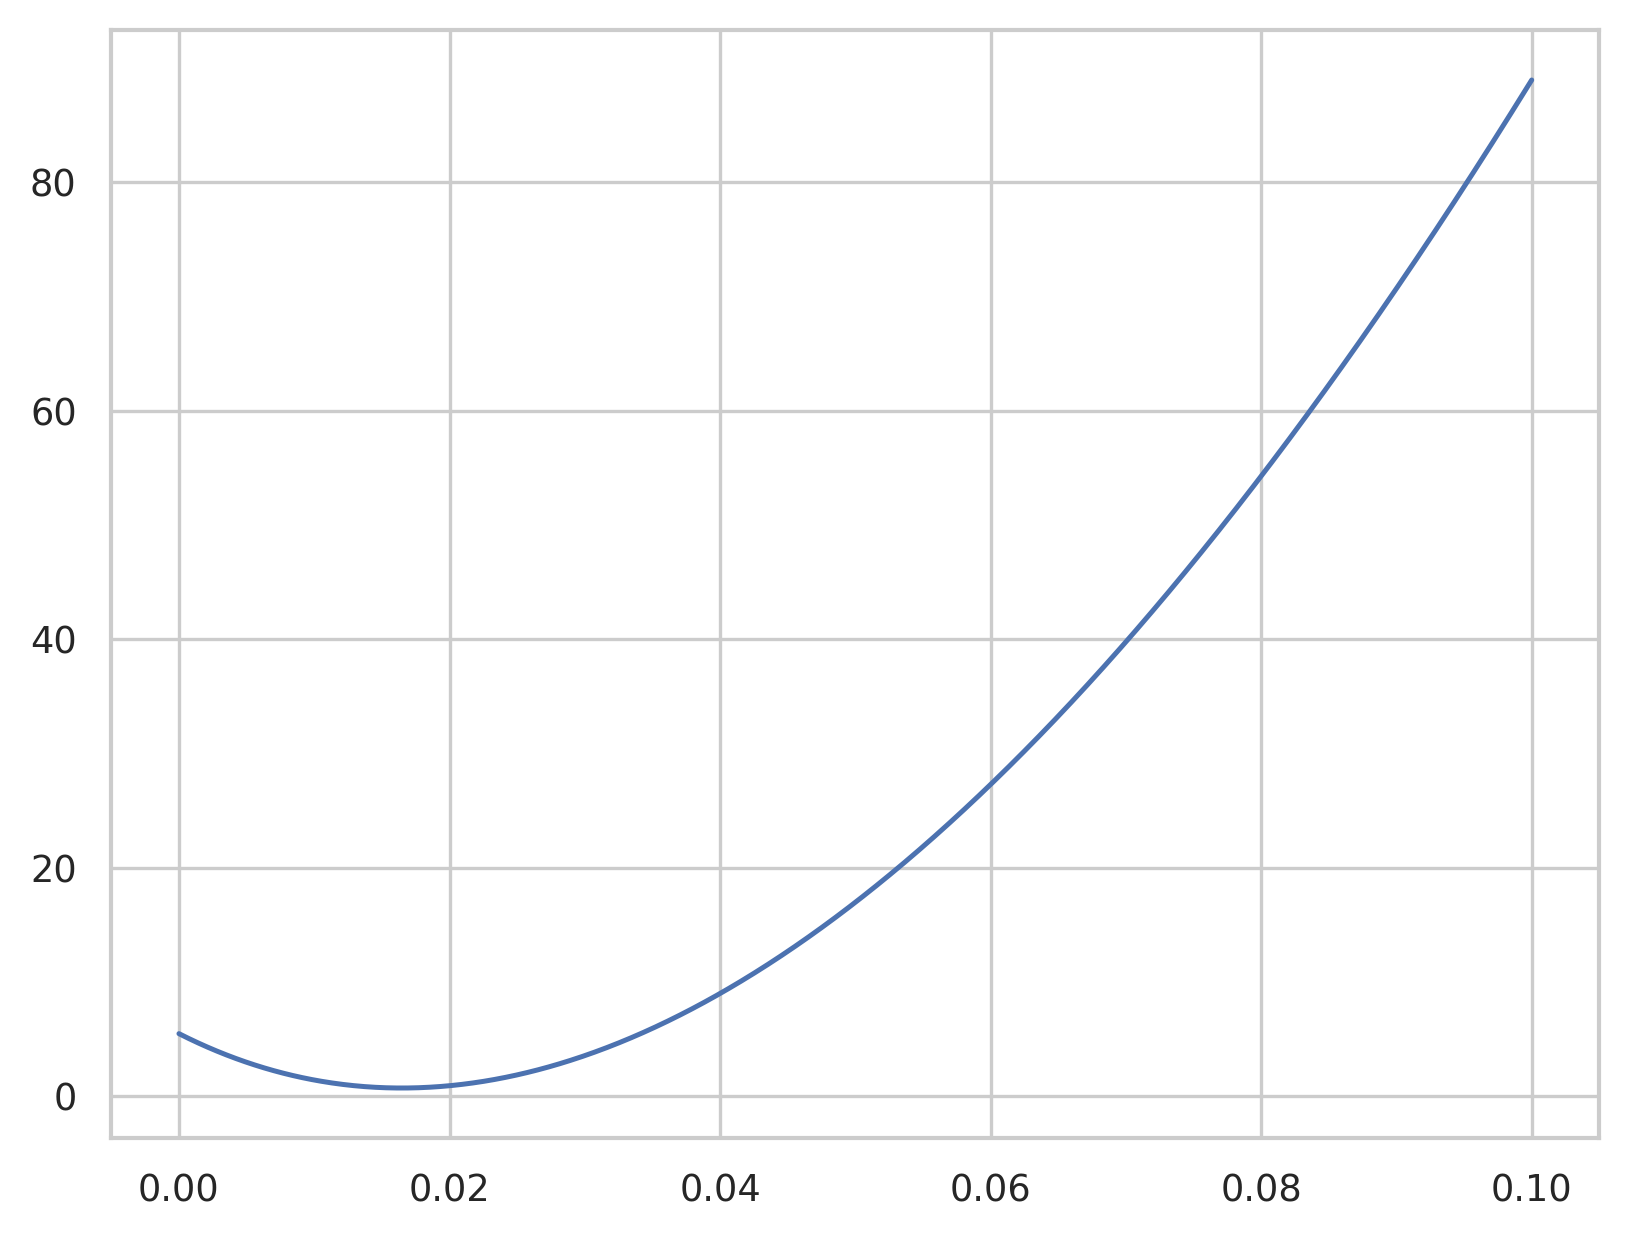

In [39]:
# let's convert A matrix values to cActivator and cInhibitor values
# start with just plotting them against each other
Kd_vals = []
err_vals = []
min_err = 9e99
best_val = None
for KdRNAPCrp in np.linspace(KdRNAP/10000000, KdRNAP/10, 1000):
    predicted_mRNA = []
    actual_mRNA = list(act_values_df.actual_mRNA)
    for index in act_values_df.index:
        cActivator 
    cActivator_cInhibitor_to_mRNA
    cActivator_vals = np.array([mRNA_to_cActivator(val, KdRNAPCrp = KdRNAPCrp) for val in act_values_df['actual_mRNA'].values]).clip(min = 0)
    cInhibitor_vals = np.array(mRNA_to_cInhibitor(inh_values_df['actual_mRNA'])).clip(min = 0)
    predicted_mRNA = cActivator_cInhibitor_to_mRNA(cActivator_vals, cInhibitor_vals)

    Kd_vals.append(KdRNAPCrp / KdRNAP)
    err = mean_squared_error(actual_mRNA, predicted_mRNA)
    if err < min_err:
        min_err = err
        best_val = KdRNAPCrp / KdRNAP
    err_vals.append(err)
plt.plot(Kd_vals, err_vals)
plt.show()

# 3D plot - I don't have access to bitome2 currently so just doing here instead of archan's stuff

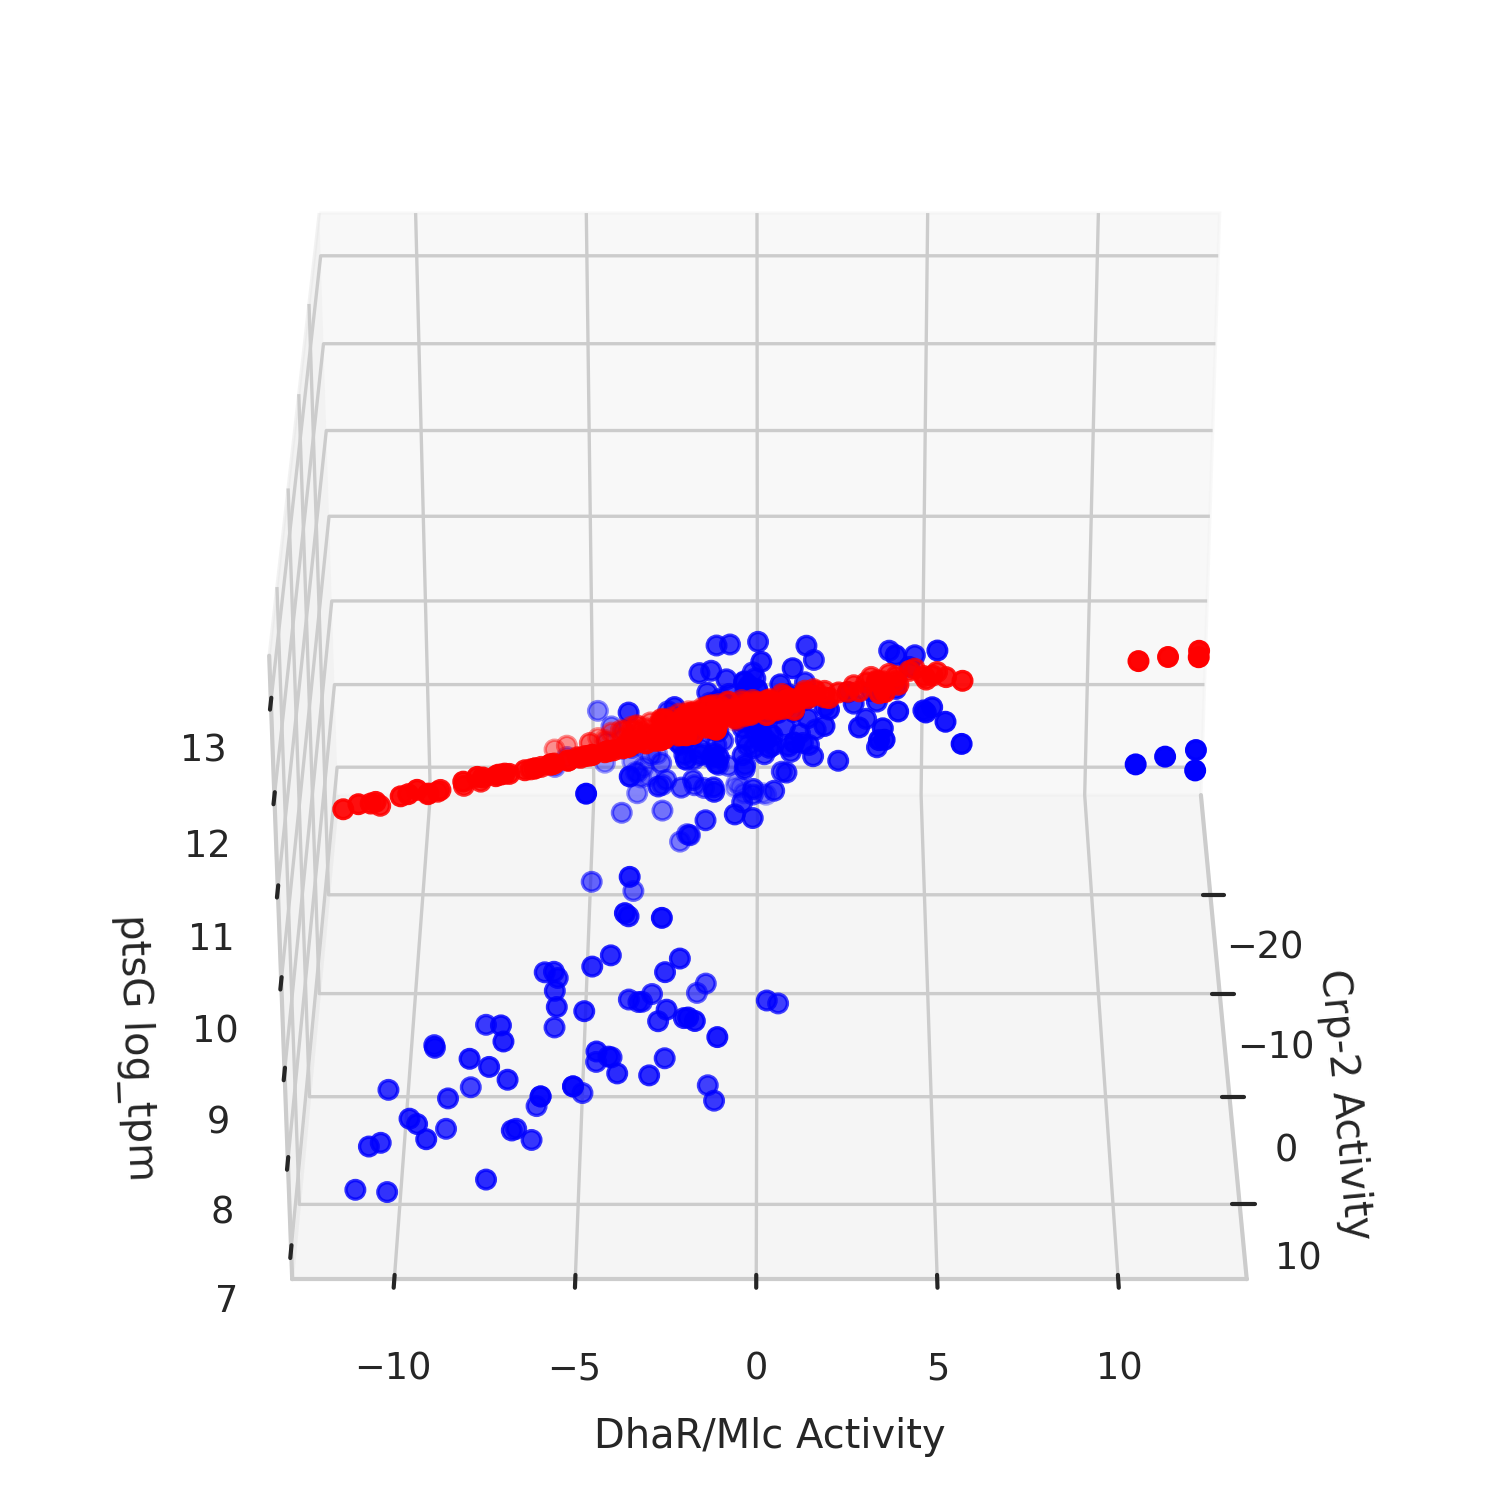

In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation

plt.rcParams["figure.dpi"] = 300
matplotlib.rcParams['pdf.fonttype'] = 42
sns.set_palette("deep")
sns.set_context("paper")
sns.set_style("whitegrid")

# data_complete is a pandas dataframe
# with the x, y, z values and color for each point as cols
fig = plt.figure()
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)
ax.scatter(A_df.loc['Crp-2'], A_df.loc['DhaR/Mlc'], preds_df['actual_log_tpm'], color = 'blue')
ax.scatter(A_df.loc['Crp-2'], A_df.loc['DhaR/Mlc'], preds_df['predicted_log_tpm'], color = 'red')
ax.set_xlabel('Crp-2 Activity')
ax.set_ylabel('DhaR/Mlc Activity')
ax.set_zlabel('ptsG log_tpm')

# this function defines the animation action done to the plot
def rotate(angle):
     ax.view_init(azim=angle)

angle = 3
ani = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 360, angle), interval=50)
ani.save('./densmap_complete.gif', writer=animation.PillowWriter(fps=10))

# playground

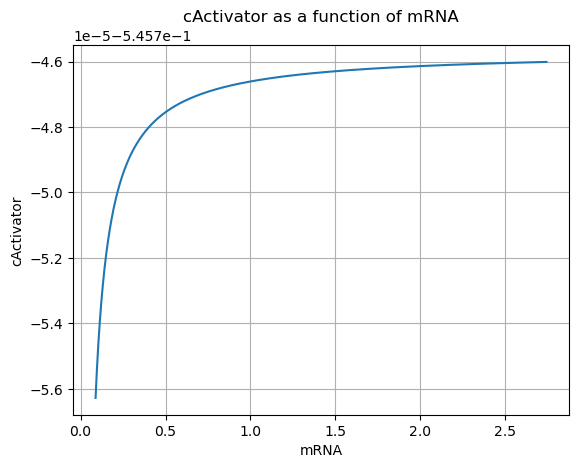

In [220]:
import numpy as np
import matplotlib.pyplot as plt

def cActivator_expression(a, b, c, d, e, f, g, h):
    numerator = a * (b + c + d * c) * (e * g - f + g * h)
    denominator = b * (e * a * g - b * f + e * g * c + e * d * g * c - f * c - d * f * c + a * g * h + g * c * h + d * g * c * h)
    return -numerator / denominator

# Define parameter values
KdRNAPCrp = 10**(-8)
KdRNAP = 1*10**(-6)
RNAP = 1*10**(-6)
KeqOpening = 10**(grid_vals[grid_use][2])
kDeg = 0.00231049
promoterConcVal = 10**(-9)
u = 1/3600

KdRNAP = 10**(grid_vals[grid_use][0])
kEscape = 10**(grid_vals[grid_use][1])
KeqOpening = 10**(grid_vals[grid_use][2])
KdRNAPCrp = KdRNAP / 10

if False:
    # Define parameter values # set from cActivator fixing
    KdRNAPCrp = 1e-07 # 10**(-7) # just magnitude # SET GOOD
    KdRNAP = 10 #1*10**(-3) # shifts left to right # SET GOOD
    RNAP = 1e-06 # 1*10**(-6) # affects spread # SET GOOD
    KeqOpening = 10**(grid_vals[grid_use][2])
    kDeg = 0.00231049
    promoterConcVal = 10**(-9)
    u = 1/3600

# Generate mRNA values
mRNA_values = np.linspace(min(act_values_df['mRNA']), max(act_values_df['mRNA']), 10000)  # Adjust the range and number of points as needed

# Evaluate cActivator for each mRNA value
cActivator_values = [cActivator_expression(KdRNAPCrp, KdRNAP, RNAP, KeqOpening, kDeg, promoterConcVal, g, u) for g in mRNA_values]

# Calculate variance of cActivator values
variance = np.var(cActivator_values)

# Find mRNA values with the highest variance
max_variance_indices = np.where(cActivator_values == np.max(cActivator_values))
mRNA_values_with_max_variance = mRNA_values[max_variance_indices]

# Plot the results
plt.plot(mRNA_values, cActivator_values)
plt.xlabel('mRNA')
plt.ylabel('cActivator')
plt.title('cActivator as a function of mRNA')
plt.grid(True)
plt.show()


0.01


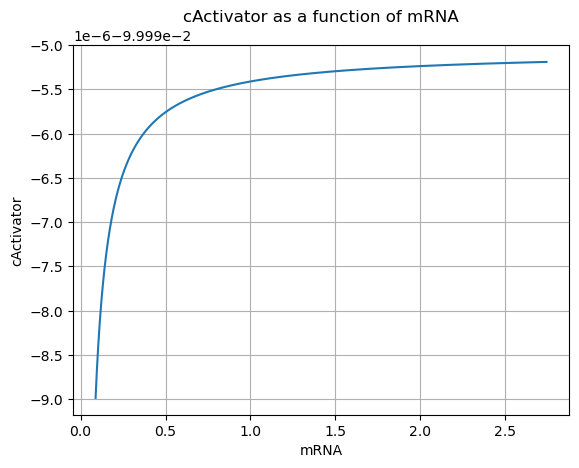

0.01


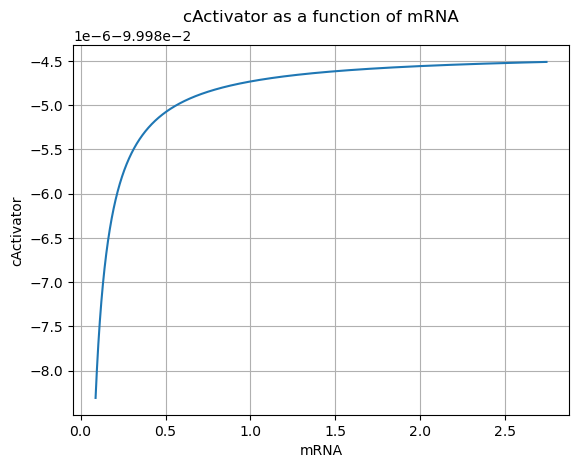

0.01


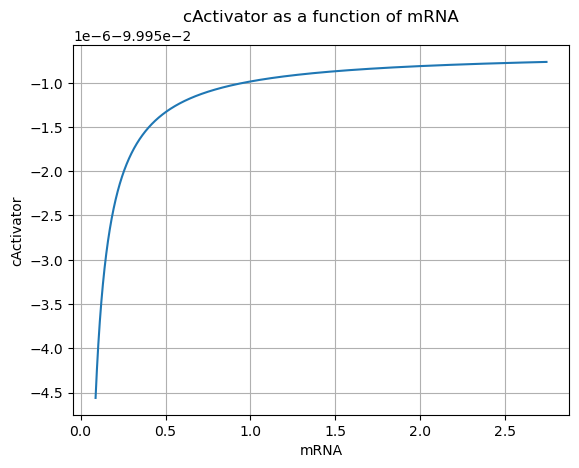

0.01


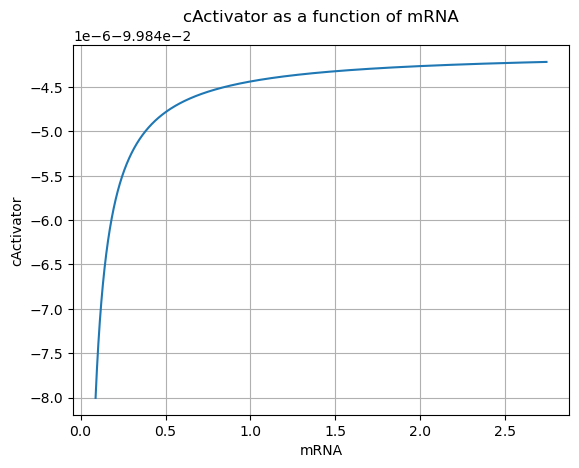

0.01


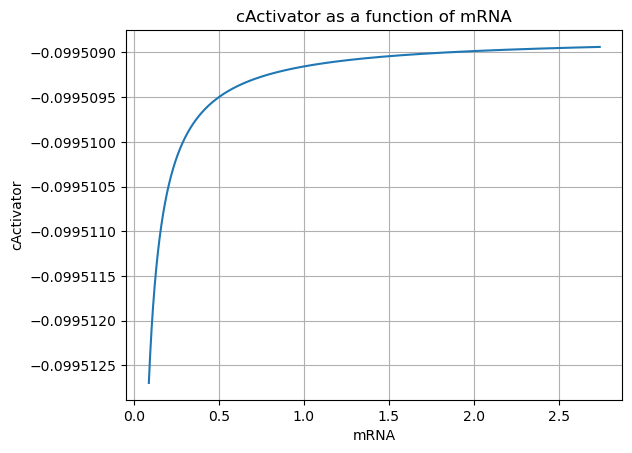

0.01


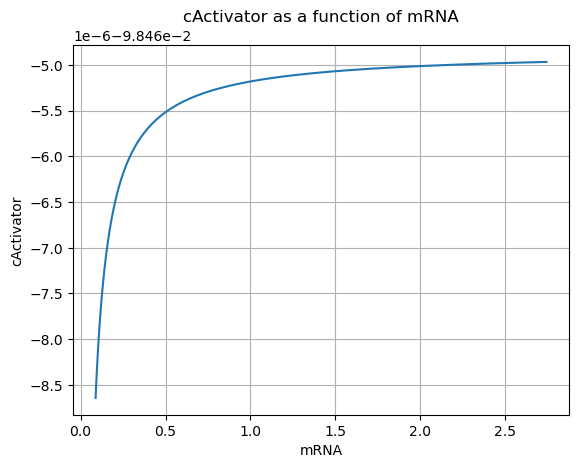

0.01


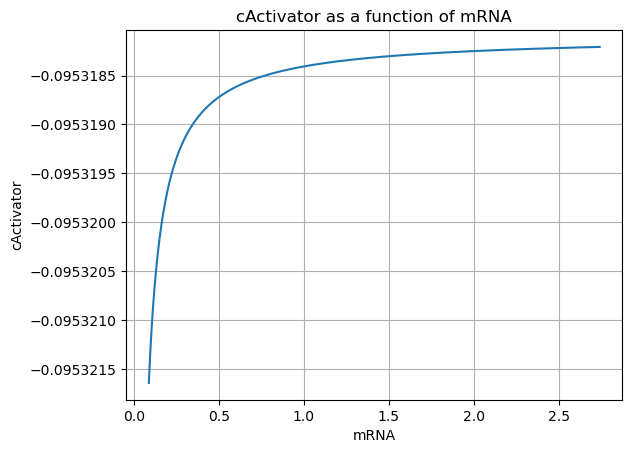

0.01


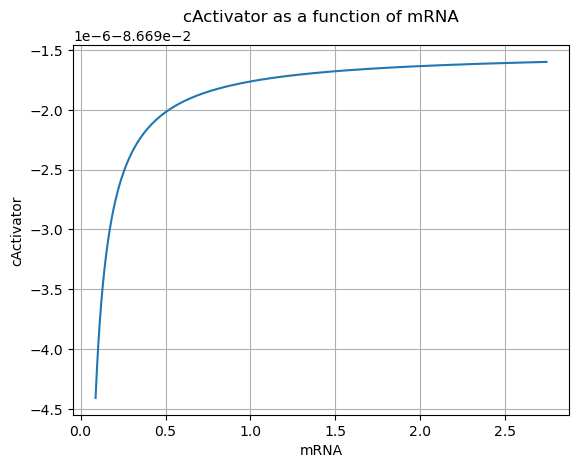

0.01


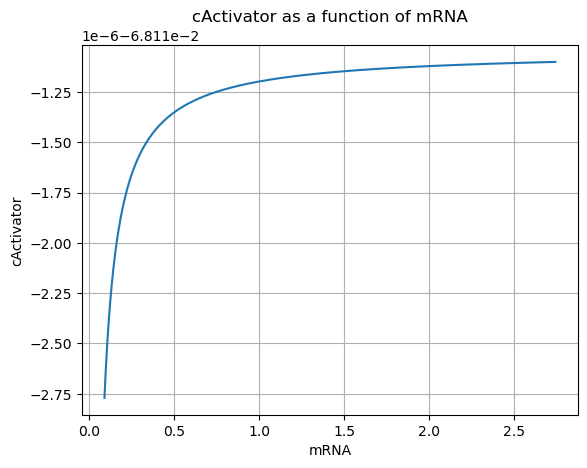

0.01


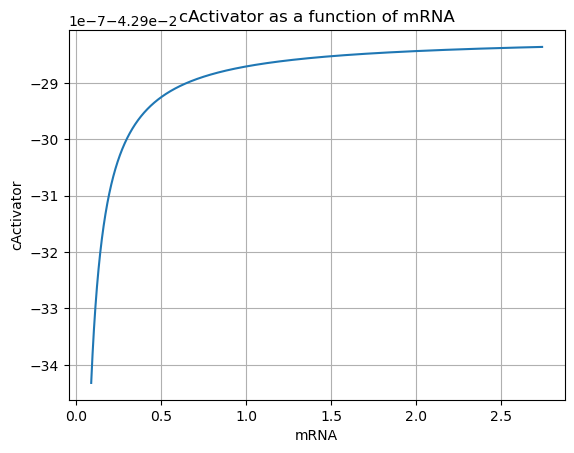

In [199]:
import numpy as np
import matplotlib.pyplot as plt

def cActivator_expression(a, b, c, d, e, f, g, h):
    numerator = a * (b + c + d * c) * (e * g - f + g * h)
    denominator = b * (e * a * g - b * f + e * g * c + e * d * g * c - f * c - d * f * c + a * g * h + g * c * h + d * g * c * h)
    return -numerator / denominator


# Define parameter values
KdRNAPCrp = 1e-07 # 10**(-7) # just magnitude # SET GOOD
KdRNAP = 10**(grid_vals[grid_use][0]) #1*10**(-3) # shifts left to right # SET GOOD
RNAP = 1e-06 # 1*10**(-6) # affects spread # SET GOOD
KeqOpening = 10**(grid_vals[grid_use][2])
kDeg = 0.00231049
promoterConcVal = 10**(-9)
u = 1/3600

if True:
    for val in range(10):
        KeqOpening_temp = KeqOpening*10**((val-5)/2)
    
        print(RNAP_temp)
        # Generate mRNA values
        mRNA_values = np.linspace(min(act_values_df['mRNA']), max(act_values_df['mRNA']), 10000)  # Adjust the range and number of points as needed

        # Evaluate cActivator for each mRNA value
        cActivator_values = [cActivator_expression(KdRNAPCrp, KdRNAP, RNAP, KeqOpening_temp, kDeg, promoterConcVal, g, u) for g in mRNA_values]

        # Calculate variance of cActivator values
        variance = np.var(cActivator_values)

        # Find mRNA values with the highest variance
        max_variance_indices = np.where(cActivator_values == np.max(cActivator_values))
        mRNA_values_with_max_variance = mRNA_values[max_variance_indices]

        # Plot the results
        plt.plot(mRNA_values, cActivator_values)
        plt.xlabel('mRNA')
        plt.ylabel('cActivator')
        plt.title('cActivator as a function of mRNA')
        plt.grid(True)
        plt.show()


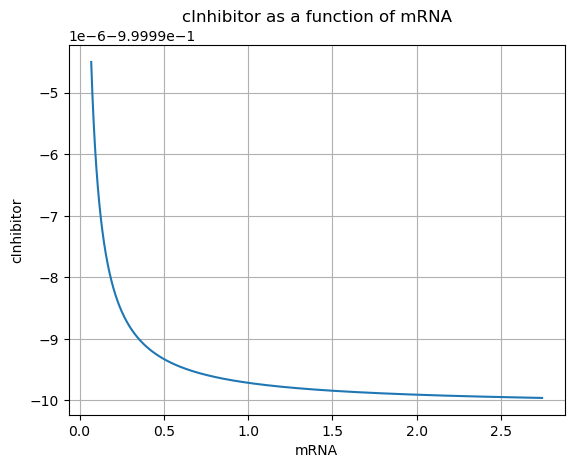

In [181]:
# SIMILAR THING AS ABOVE BUT FOR CINHIBITOR


import numpy as np
import matplotlib.pyplot as plt

def cActivator_expression(a, b, c, d, e, f, g, h):
    numerator = a * (b + c + d * c) * (e * g - f + g * h)
    denominator = b * (e * a * g - b * f + e * g * c + e * d * g * c - f * c - d * f * c + a * g * h + g * c * h + d * g * c * h)
    return -numerator / denominator

# Define parameter values
KdRNAPCrp = 10**(-8)
KdRNAP = 1*10**(-6)
RNAP = 1*10**(-6)
KeqOpening = 10**(grid_vals[grid_use][2])
kDeg = 0.00231049
promoterConcVal = 10**(-9)
u = 1/3600

# Define parameter values # set from cActivator fixing
KdRNAPCrp = 1e-07 
KdRNAP = 10 
RNAP = 1e-06 
KeqOpening = 10**(grid_vals[grid_use][2])
kDeg = 0.00231049
promoterConcVal = 10**(-9)
u = 1/3600

# Generate mRNA values
mRNA_values = np.linspace(min(inh_values_df['mRNA']), max(inh_values_df['mRNA']), 10000)  # Adjust the range and number of points as needed

# Evaluate cActivator for each mRNA value
cActivator_values = [mRNA_to_cInhibitor(g, KdRNAP = KdRNAP, RNAP = RNAP, KeqOpening = KeqOpening) for g in mRNA_values]

# Calculate variance of cActivator values
variance = np.var(cActivator_values)

# Find mRNA values with the highest variance
max_variance_indices = np.where(cActivator_values == np.max(cActivator_values))
mRNA_values_with_max_variance = mRNA_values[max_variance_indices]


# Plot the results
plt.plot(mRNA_values, cActivator_values)
plt.xlabel('mRNA')
plt.ylabel('cInhibitor')
plt.title('cInhibitor as a function of mRNA')
plt.grid(True)
plt.show()


1.908860976328061e-07


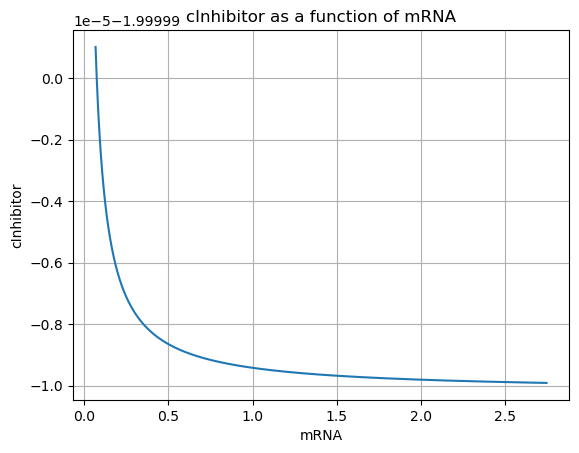

1.908860976328061e-06


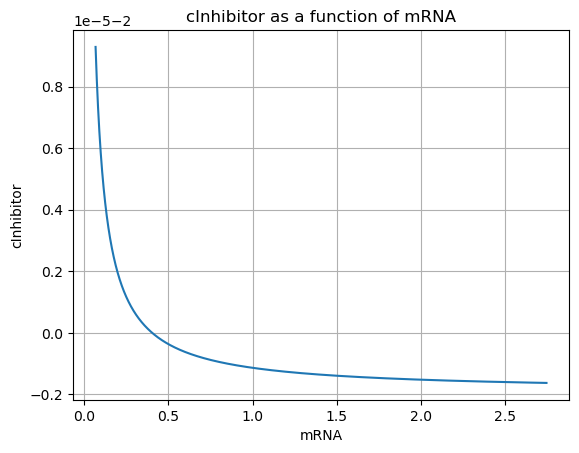

1.908860976328061e-05


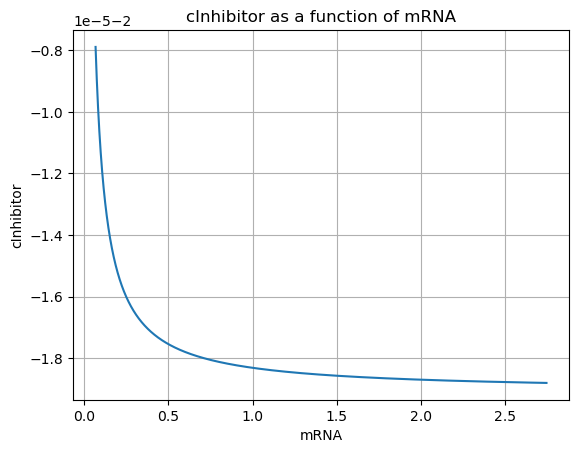

0.00019088609763280608


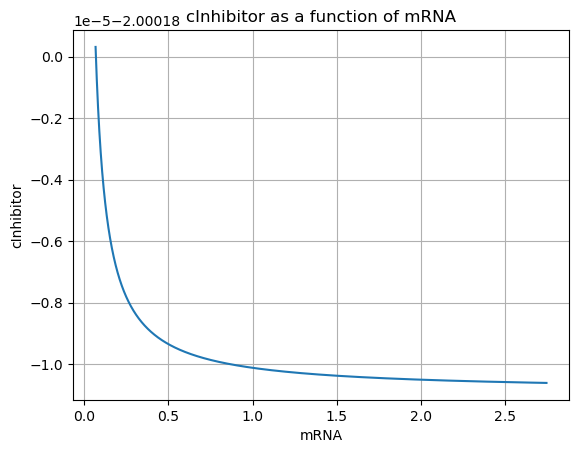

0.001908860976328061


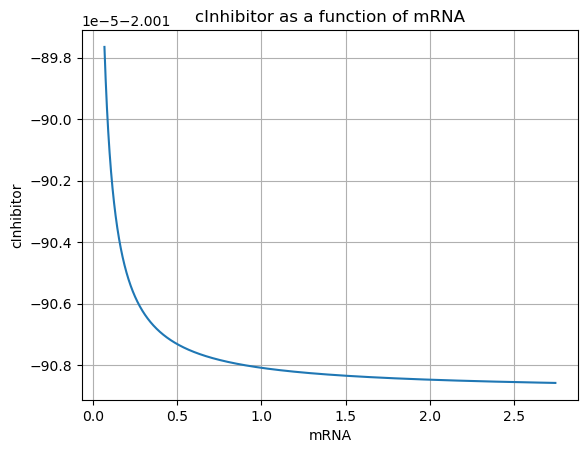

0.01908860976328061


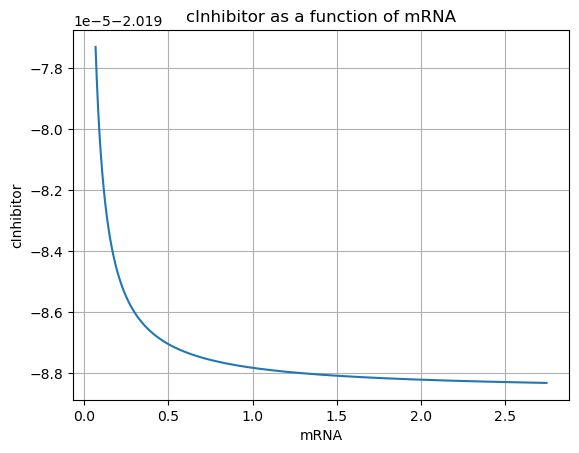

0.1908860976328061


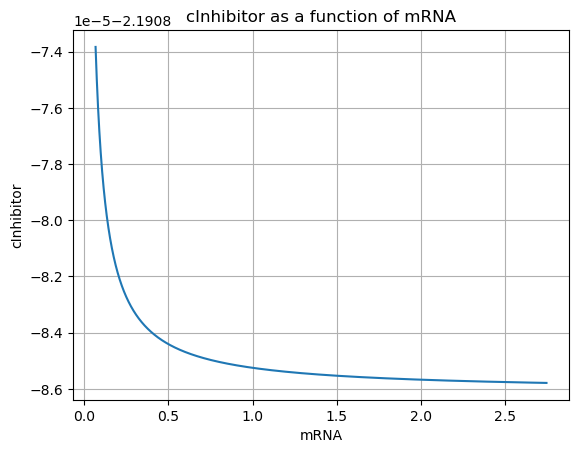

1.9088609763280608


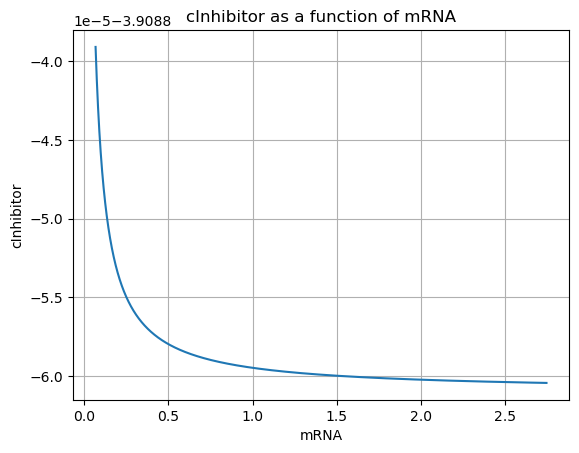

19.08860976328061


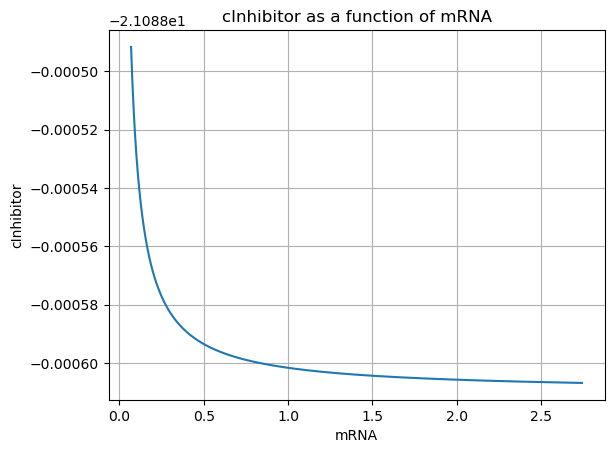

190.88609763280607


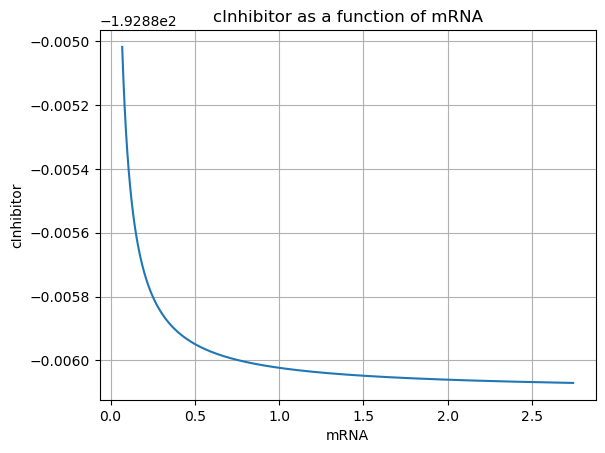

In [186]:
# SIMILAR THING AS ABOVE BUT FOR CINHIBITOR


import numpy as np
import matplotlib.pyplot as plt

def cActivator_expression(a, b, c, d, e, f, g, h):
    numerator = a * (b + c + d * c) * (e * g - f + g * h)
    denominator = b * (e * a * g - b * f + e * g * c + e * d * g * c - f * c - d * f * c + a * g * h + g * c * h + d * g * c * h)
    return -numerator / denominator

# Define parameter values
KdRNAPCrp = 10**(-8)
KdRNAP = 1*10**(-6)
RNAP = 1*10**(-6)
KeqOpening = 10**(grid_vals[grid_use][2])
kDeg = 0.00231049
promoterConcVal = 10**(-9)
u = 1/3600

# Define parameter values # set from cActivator fixing
KdRNAP = 10 
RNAP = 1e-06 
KeqOpening = 10**(grid_vals[grid_use][2]) # scale changes, maybe pos/neg?
kDeg = 0.00231049
promoterConcVal = 10**(-9)
u = 1/3600

if True:
    for val in range(10):
        kDeg_temp = kDeg*10**((val-5))
    
        print(kDeg_temp)
        # Generate mRNA values
        mRNA_values = np.linspace(min(inh_values_df['mRNA']), max(inh_values_df['mRNA']), 10000)  # Adjust the range and number of points as needed

        # Evaluate cActivator for each mRNA value
        cActivator_values = [mRNA_to_cInhibitor(g, KdRNAP = KdRNAP, RNAP = KdRNAP, KeqOpening = KeqOpening_temp) for g in mRNA_values]

        # Calculate variance of cActivator values
        variance = np.var(cActivator_values)

        # Find mRNA values with the highest variance
        max_variance_indices = np.where(cActivator_values == np.max(cActivator_values))
        mRNA_values_with_max_variance = mRNA_values[max_variance_indices]


        # Plot the results
        plt.plot(mRNA_values, cActivator_values)
        plt.xlabel('mRNA')
        plt.ylabel('cInhibitor')
        plt.title('cInhibitor as a function of mRNA')
        plt.grid(True)
        plt.show()


In [ ]:
(((KdRNAP + RNAP + KeqOpening*RNAP)*(kDeg*mRNA - promoterConcVal + \
                    mRNA*u))/(KdRNAP*mRNA*(kDeg + u)))